In [10]:
data_root_path = '../../data/Disease_classification_loo/'
figure_root_path = './Figures/'

/tmp/ipykernel_229006/1848511030.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_229006/1848511030.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_229006/1848511030.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_229006/1848511030.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 an

提示：fig.tight_layout 使用的 rect=[0, 0.01, 1, 0.46] 参数会严重限制图表的垂直空间。
如果图表垂直方向显得过于压缩，请考虑调整 rect 参数，例如改为 rect=[0, 0.03, 1, 0.95] 或完全移除该参数。


/tmp/ipykernel_229006/1848511030.py:300: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.5) # pad can help, adjust as needed


图形已保存为 diseases_roc_plot.png


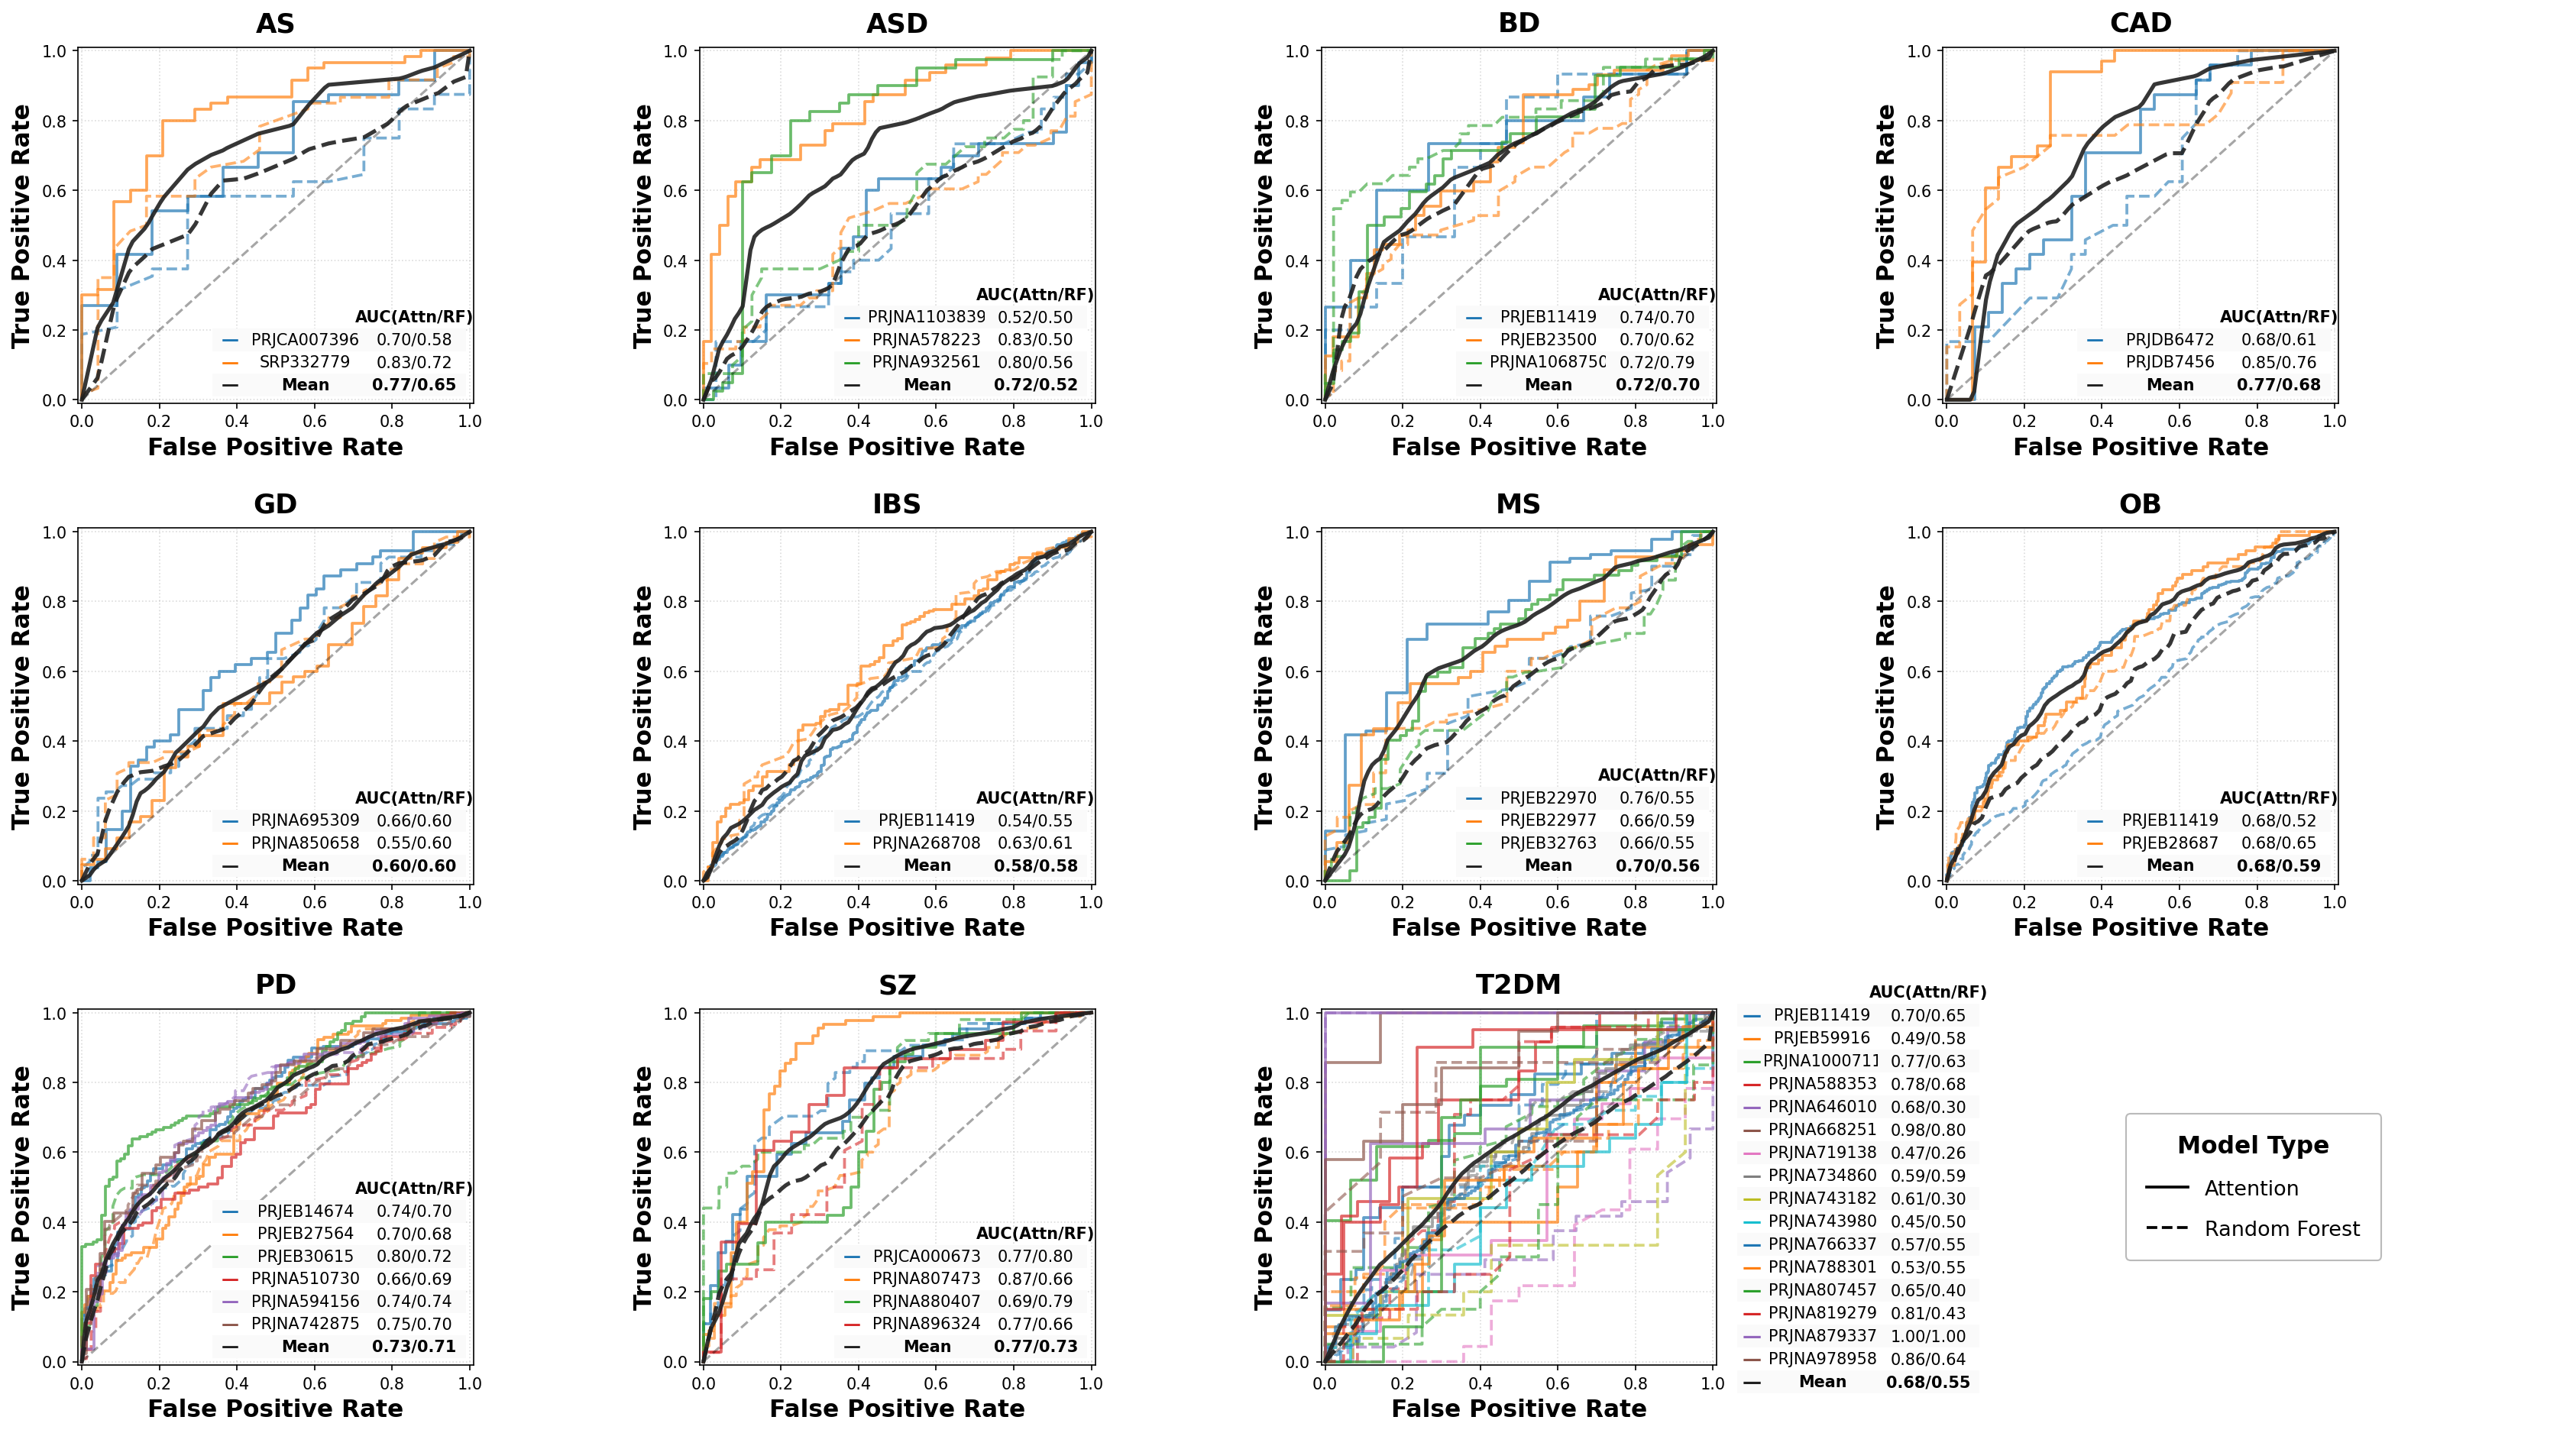

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np
from sklearn.metrics import auc
from matplotlib.lines import Line2D # For custom legend
from matplotlib.colors import to_rgba # For color manipulation
import math # For math.ceil

# Configure global parameters
plt.rcParams['axes.unicode_minus'] = False

# 路径配置
data_path = data_root_path + "all_model_loo.csv"
result_base = data_root_path +"disease_data"

# 读取数据
# Read data
try:
    df = pd.read_csv(data_path)
except FileNotFoundError:
    print(f"错误：数据文件 '{data_path}' 未找到。请检查路径。")
    df = pd.DataFrame(columns=['disease_name_ab', 'study'])
    # exit() # In a real scenario, you might exit here

disease_studies_all = df.groupby('disease_name_ab')['study'].unique().apply(list).to_dict()

# --- Filter out specified diseases ---
excluded_diseases = ['IBD', 'CRC', 'PC'] 
disease_studies_to_plot = {
    disease: studies
    for disease, studies in disease_studies_all.items()
    if disease not in excluded_diseases
}

if not disease_studies_to_plot:
    print(f"过滤后未找到任何疾病数据进行绘图。")
    all_disease_names_sorted = []
else:
    all_disease_names_sorted = sorted(list(disease_studies_to_plot.keys()))

num_diseases_total = len(all_disease_names_sorted)
plots_per_row = 4

if num_diseases_total == 0:
    print("没有疾病数据可供绘制，将生成一个空图。")
    num_grid_rows_main = 1
    num_grid_cols_main = 1
else:
    num_grid_rows_main = math.ceil(num_diseases_total / plots_per_row)
    num_grid_cols_main = min(plots_per_row, num_diseases_total)

# Figure size adjustments
# width_per_disease_group defines the width of one entire plot cell in gs_main.
# This cell will be internally divided for ROC + (Table for T2DM or Padding for others).
width_per_disease_group = 7.0 
height_per_row = 5.0 

total_fig_width = num_grid_cols_main * width_per_disease_group
total_fig_height = num_grid_rows_main * height_per_row

fig = plt.figure(figsize=(total_fig_width, total_fig_height), dpi=150)

# --- Main GridSpec ---
gs_main = gridspec.GridSpec(num_grid_rows_main, num_grid_cols_main, figure=fig, 
                            wspace=0.00, # Small gap between disease plot groups
                            hspace=0.33) 

# --- Color configuration ---
def get_tab10_colors(n):
    cmap = plt.cm.get_cmap('tab10')
    if cmap is None: return ['blue'] * n
    num_colors_in_map = cmap.N
    if n <= 0: return []
    return [cmap(i % num_colors_in_map) for i in range(n)]

def get_seaborn_distinct_colors(n_colors, palette_type="husl"):
    colors = sns.color_palette(palette_type, n_colors=n_colors)
    return colors

mean_line_color = '#202020'
row_color_even = '#FAFAFA'
row_color_odd = '#FFFFFF'

# --- Iterate through diseases to create plots and tables ---
if num_diseases_total > 0:
    for plot_idx, disease_ab in enumerate(all_disease_names_sorted):
        if disease_ab not in disease_studies_to_plot:
            print(f"警告：在 disease_studies_to_plot 中未找到疾病 {disease_ab} 的研究数据。跳过此疾病。")
            continue
        studies_for_disease = disease_studies_to_plot[disease_ab]

        current_row_main = plot_idx // plots_per_row
        current_col_main = plot_idx % plots_per_row
        
        is_t2dm = (disease_ab == "T2DM")
        
        # Define default internal layout parameters (these match your original global settings)
        default_internal_width_ratios = [2.8, 1.2]
        default_internal_wspace = 0.20  # Original minimal space
        
        # Define T2DM-specific internal layout parameters
        # We will primarily increase the wspace to move the table away from the ROC curve.
        # The width_ratios can also be adjusted if the table itself needs more relative space.

        current_plot_internal_width_ratios = default_internal_width_ratios
        current_plot_internal_wspace = default_internal_wspace

        if is_t2dm:
            t2dm_specific_wspace = 0.20
            t2dm_specific_width_ratios = [2.8, 1.2]
            current_plot_internal_width_ratios = t2dm_specific_width_ratios
            current_plot_internal_wspace = t2dm_specific_wspace
            
        gs_internal_plot_cell = gridspec.GridSpecFromSubplotSpec(
            1, 2, subplot_spec=gs_main[current_row_main, current_col_main],
            width_ratios=current_plot_internal_width_ratios,
            wspace=current_plot_internal_wspace  # This will now be larger for T2DM
        )
        
        # --- ROC Curve Subplot (Left part of the internal grid) ---
        # All ROC curves are drawn in this subplot, which has a consistent size.
        ax_roc = fig.add_subplot(gs_internal_plot_cell[0, 0]) 
        
        # --- Table Configuration ---
        current_table_target_ax = None
        current_table_loc = ''
        current_table_fontsize = 0
        current_table_col_widths = []
        current_table_scale_y = 1.0

        if is_t2dm:
            # T2DM: Table in the right part of the internal grid
            ax_table_area_for_t2dm = fig.add_subplot(gs_internal_plot_cell[0, 1])
            ax_table_area_for_t2dm.axis('off') 
            
            current_table_target_ax = ax_table_area_for_t2dm
            current_table_loc = 'center' 
            current_table_fontsize = 10 
            current_table_col_widths = [0.18, 0.65, 0.60] # [Symbol, Name, AUCs]
            current_table_scale_y = 1.2
        else:
            # Other diseases: Table inside ax_roc (left part). Right part of internal grid is empty.
            ax_empty_padding_area = fig.add_subplot(gs_internal_plot_cell[0, 1])
            ax_empty_padding_area.axis('off') # Keep this space for layout consistency

            current_table_target_ax = ax_roc # Table will be inside the ROC plot axes
            current_table_loc = 'lower right'
            current_table_fontsize = 10 # Slightly smaller for in-plot table
            current_table_col_widths = [0.09, 0.29, 0.26] # Original for in-plot
            current_table_scale_y = 1.2 # Slightly smaller scale for in-plot


        # --- ROC curve plotting logic (common to all) ---
        sorted_studies = sorted(list(studies_for_disease))
        colors = get_tab10_colors(len(sorted_studies))
        # colors = get_seaborn_distinct_colors(len(sorted_studies), palette_type="husl")
        study_color_map = {study: colors[i] for i, study in enumerate(sorted_studies)}

        all_attn_tpr, all_rf_tpr = [], []
        attn_aucs_for_mean, rf_aucs_for_mean = [], []
        fpr_common = np.linspace(0, 1, 100)
        table_data_for_styling = []

        for study_idx, study in enumerate(sorted_studies):
            study_dir = os.path.join(result_base, disease_ab, study, 'results')
            study_dir_RF = os.path.join(result_base, disease_ab, study, 'RF')
            current_study_color = study_color_map[study]
            try:
                rf_roc_orig = pd.read_csv(os.path.join(study_dir_RF, "RF_ROC.csv"))
                attn_roc_orig = pd.read_csv(os.path.join(study_dir, "roc_curve.csv"))
                rf_roc, attn_roc = rf_roc_orig.copy(), attn_roc_orig.copy()
                
                rf_auc_val, attn_auc_val = auc(rf_roc['FPR'], rf_roc['TPR']), auc(attn_roc['FPR'], attn_roc['TPR'])
                rf_auc_rounded, attn_auc_rounded = round(rf_auc_val, 2), round(attn_auc_val, 2)
                attn_aucs_for_mean.append(attn_auc_val); rf_aucs_for_mean.append(rf_auc_val)
                
                attn_roc_sorted = attn_roc.drop_duplicates(subset=['FPR']).sort_values('FPR')
                rf_roc_sorted = rf_roc.drop_duplicates(subset=['FPR']).sort_values('FPR')
                
                attn_fpr_interp = np.concatenate(([0], attn_roc_sorted['FPR'].values, [1]))
                attn_tpr_interp = np.concatenate(([0], attn_roc_sorted['TPR'].values, [1]))
                rf_fpr_interp = np.concatenate(([0], rf_roc_sorted['FPR'].values, [1]))
                rf_tpr_interp = np.concatenate(([0], rf_roc_sorted['TPR'].values, [1]))
                
                attn_df_interp = pd.DataFrame({'FPR': attn_fpr_interp, 'TPR': attn_tpr_interp}).drop_duplicates(subset=['FPR']).sort_values('FPR')
                rf_df_interp = pd.DataFrame({'FPR': rf_fpr_interp, 'TPR': rf_tpr_interp}).drop_duplicates(subset=['FPR']).sort_values('FPR')

                all_attn_tpr.append(np.interp(fpr_common, attn_df_interp['FPR'], attn_df_interp['TPR']))
                all_rf_tpr.append(np.interp(fpr_common, rf_df_interp['FPR'], rf_df_interp['TPR']))
                
                ax_roc.plot(attn_roc['FPR'], attn_roc['TPR'], color=current_study_color, linestyle='-', linewidth=1.8, alpha=0.7)
                ax_roc.plot(rf_roc['FPR'], rf_roc['TPR'], color=current_study_color, linestyle='--', linewidth=1.8, alpha=0.6)
                table_data_for_styling.append({'color': current_study_color, 'name': study, 'auc_text': f"{attn_auc_rounded:.2f}/{rf_auc_rounded:.2f}", 'is_mean': False, 'row_idx': study_idx})
            except FileNotFoundError:
                print(f"警告：{disease_ab} - {study} 的ROC文件未找到。路径: {study_dir_RF} 或 {study_dir}")
                table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Miss)", 'auc_text': "N/A", 'is_mean': False, 'row_idx': study_idx})
            except Exception as e:
                print(f"处理 {disease_ab} - {study} 时出错：{str(e)}")
                table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Err)", 'auc_text': "Error", 'is_mean': False, 'row_idx': study_idx})

        if attn_aucs_for_mean and rf_aucs_for_mean:
            mean_attn_auc_val, mean_rf_auc_val = np.mean(attn_aucs_for_mean), np.mean(rf_aucs_for_mean)
            mean_attn_auc_rounded, mean_rf_auc_rounded = round(mean_attn_auc_val, 2), round(mean_rf_auc_val, 2)
            if all_attn_tpr and all_rf_tpr:
                mean_attn_tpr, mean_rf_tpr = np.mean(all_attn_tpr, axis=0), np.mean(all_rf_tpr, axis=0)
                mean_attn_tpr[0], mean_attn_tpr[-1] = 0,1; mean_rf_tpr[0], mean_rf_tpr[-1] = 0,1
                ax_roc.plot(fpr_common, mean_attn_tpr, color=mean_line_color, linestyle='-', linewidth=2.5, alpha=0.9, zorder=10)
                ax_roc.plot(fpr_common, mean_rf_tpr, color=mean_line_color, linestyle='--', linewidth=2.5, alpha=0.9, zorder=10)
            table_data_for_styling.append({'color': mean_line_color, 'name': "Mean", 'auc_text': f"{mean_attn_auc_rounded:.2f}/{mean_rf_auc_rounded:.2f}", 'is_mean': True, 'row_idx': len(sorted_studies)})

        # --- ROC plot styling (common to all ax_roc) ---
        ax_roc.plot([0,1],[0,1],'k--',alpha=0.35,zorder=5)
        ax_roc.set_xlim([-0.01,1.01]); ax_roc.set_ylim([-0.01,1.01])
        ax_roc.set_aspect(0.9, adjustable='box') # Allow aspect to be controlled by figure/subplot size
        ax_roc.set_title(f"{disease_ab}",fontsize=17,pad=10,weight='bold')
        ax_roc.set_xlabel('False Positive Rate',fontsize=15,weight='bold')
        ax_roc.set_ylabel('True Positive Rate',fontsize=15, weight='bold')
        ax_roc.grid(True,linestyle=':',alpha=0.45,zorder=1)
        ax_roc.tick_params(axis='both',which='major',labelsize=10)

        # --- Table plotting logic (uses current_table_target_ax) ---
        if table_data_for_styling and current_table_target_ax:
            cell_text_for_plt_table = [['\u2014', item['name'], item['auc_text']] for item in table_data_for_styling]
            col_labels_for_table = [' ', ' ', 'AUC(Attn/RF)']
            
            the_table = current_table_target_ax.table(cellText=cell_text_for_plt_table, colLabels=col_labels_for_table,
                                                     loc=current_table_loc, colWidths=current_table_col_widths)
            the_table.auto_set_font_size(False)
            the_table.set_fontsize(current_table_fontsize)
            the_table.scale(1, current_table_scale_y)

            for (row, col), cell in the_table.get_celld().items():
                cell.set_linewidth(0); cell.set_edgecolor('none')
                cell.set_text_props(ha='center', va='center')
                if row == 0: 
                    cell.set_facecolor('none'); cell.set_text_props(weight='bold', color='black')
                    if col < 2: cell.get_text().set_text('') 
                else: 
                    current_row_data = table_data_for_styling[row-1]
                    bg_color = row_color_even if current_row_data.get('row_idx', row-1) % 2 == 0 else row_color_odd
                    if current_row_data['is_mean']: bg_color = row_color_even 
                    cell.set_facecolor(bg_color)
                    
                    if col == 0: 
                        cell.get_text().set_color(current_row_data['color'])
                        cell.get_text().set_weight('bold')
                        dash_fontsize_increment = 1
                        # For external T2DM table or internal tables, adjust dash size based on table font size
                        if is_t2dm: # External table for T2DM
                             dash_fontsize_increment = 2
                        else: # Internal table for others
                             dash_fontsize_increment = 1 # Can be smaller if table font is smaller
                        cell.get_text().set_fontsize(current_table_fontsize + dash_fontsize_increment)
                    
                    if current_row_data['is_mean'] and col > 0:
                        cell.set_text_props(weight='bold')
            
            if not is_t2dm: # Table is inside ax_roc for other diseases
                the_table.set_zorder(20) 

# --- GLOBAL LEGEND CREATION ---
legend_elements_global = [
    Line2D([0], [0], color='black', lw=1.8, linestyle='-', label='Attention'),
    Line2D([0], [0], color='black', lw=1.8, linestyle='--', label='Random Forest')
]
legend_placed_in_cell = False
possible_legend_cells = []
for r_idx in range(num_grid_rows_main):
    for c_idx in range(num_grid_cols_main):
        linear_idx = r_idx * num_grid_cols_main + c_idx
        is_cell_used_by_plot = linear_idx < num_diseases_total
        if not is_cell_used_by_plot:
            possible_legend_cells.append((r_idx, c_idx))

if possible_legend_cells:
    legend_cell_r, legend_cell_c = possible_legend_cells[-1] 
    ax_legend_container = fig.add_subplot(gs_main[legend_cell_r, legend_cell_c])
    ax_legend_container.axis('off') 
    the_legend = ax_legend_container.legend(handles=legend_elements_global, loc='center', fontsize=13, 
                               frameon=True, edgecolor='darkgrey', borderpad=1.0, labelspacing=1.0,
                               title='Model Type', title_fontsize='15')
    the_legend.get_title().set_fontweight('bold')
    legend_placed_in_cell = True

if not legend_placed_in_cell and num_diseases_total > 0: 
    fig.legend(handles=legend_elements_global, loc='lower right', bbox_to_anchor=(0.98, 0.03), 
               ncol=1, fontsize=10, frameon=True, edgecolor='darkgrey',title='Model Type', title_fontsize='11')
elif num_diseases_total == 0:
    print("图中没有绘制任何内容，因此不添加图例。")

# --- Final Layout Adjustment ---
print("提示：fig.tight_layout 使用的 rect=[0, 0.01, 1, 0.46] 参数会严重限制图表的垂直空间。")
print("如果图表垂直方向显得过于压缩，请考虑调整 rect 参数，例如改为 rect=[0, 0.03, 1, 0.95] 或完全移除该参数。")
try:
    # The wspace in gs_main and gs_internal_plot_cell might interact with tight_layout.
    # Using tight_layout() without rect first to see if it spaces things better.
    # Then, if rect is critical, it can be applied, or adjust subplotpars.
    fig.tight_layout(pad=0.5) # pad can help, adjust as needed
    # If you must use rect:
    # fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.90, wspace=0.1, hspace=0.35)
    # instead of tight_layout with rect if rect causes issues.
    # For now, let's try tight_layout with the original rect, but it's risky.
    # fig.tight_layout(pad=0.3, rect=[0, 0.01, 1, 0.46]) # This line is problematic
except ValueError as e:
    print(f"调用 fig.tight_layout 时发生错误: {e}")
    print("尝试不使用 rect 参数进行调整。")
    try:
        fig.tight_layout(pad=1.0) # Increased padding
    except Exception as e_inner:
        print(f"不使用 rect 参数调用 fig.tight_layout 时仍然失败: {e_inner}")


output_filename = "diseases_roc_plot.png"
try:
    plt.savefig(figure_root_path + output_filename, dpi=300, facecolor='white', bbox_inches='tight')
    print(f"图形已保存为 {output_filename}")
except Exception as e:
    print(f"保存图形时出错：{e}")

plt.show()

/tmp/ipykernel_229006/4078808635.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_229006/4078808635.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


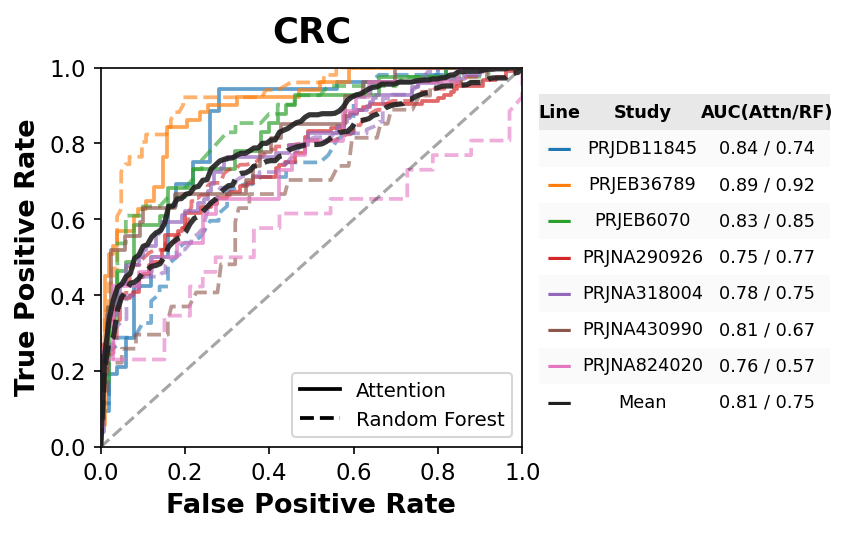

图形 'roc_plot_CRC.png' 已保存。


/tmp/ipykernel_229006/4078808635.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_229006/4078808635.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


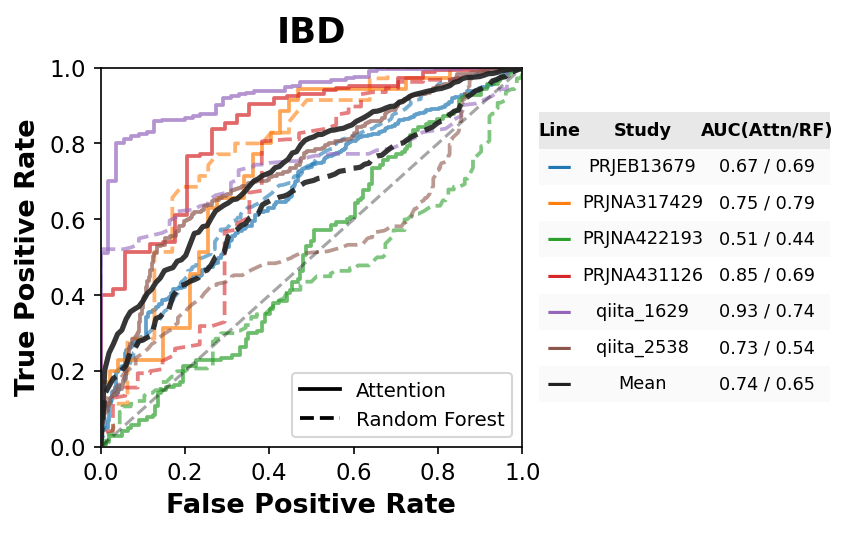

图形 'roc_plot_IBD.png' 已保存。
所有选定疾病的ROC图已单独生成完毕。


In [12]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np
from sklearn.metrics import auc
from matplotlib.lines import Line2D # For custom legend
from matplotlib.colors import to_rgba # For color manipulation
import math # For math.ceil

# Configure global parameters
plt.rcParams['axes.unicode_minus'] = False

# Path configuration
# IMPORTANT: Please ensure these paths are correct for your environment.
data_path = data_root_path + "all_model_loo.csv"
result_base = data_root_path +"disease_data"


# Read data
try:
    df = pd.read_csv(data_path)
except FileNotFoundError:
    print(f"错误：数据文件 '{data_path}' 未找到。请检查路径。")
    df = pd.DataFrame(columns=['disease_name_ab', 'study'])
    exit()

disease_studies_all = df.groupby('disease_name_ab')['study'].unique().apply(list).to_dict()

# --- Filter for specific diseases and prepare layout ---
# This list determines which diseases will have individual plots generated.
target_diseases = ['IBD', 'CRC'] 
disease_studies_to_plot = {
    disease: studies
    for disease, studies in disease_studies_all.items()
    if disease in target_diseases
}

if not disease_studies_to_plot:
    print(f"未找到目标疾病的数据：{', '.join(target_diseases)}")
    exit()

# Get a sorted list of disease names for consistent processing order
all_disease_names_to_plot_sorted = sorted(list(disease_studies_to_plot.keys()))


# Define dimensions for each individual plot (ROC plot + Table)
# These were previously width_per_disease_group and fig_height_inches (used as height_per_row)
single_plot_width = 6 # inches 
single_plot_height = 4.2 # inches 

# --- Color configuration ---
def get_tab10_colors(n): # Renamed from get_set3_colors as it uses 'tab10'
    """Generates colors from the tab10 (Tableau10) colormap, cycling if necessary."""
    cmap = plt.cm.get_cmap('tab10') 
    num_colors_in_map = cmap.N 
    if n <= 0: return []
    return [cmap(i % num_colors_in_map) for i in range(n)]

# Parameters for individual study lines (from your provided code)
study_line_linewidth = 1.8
study_line_alpha_attn = 0.7 # From your code for Attention study lines
study_line_alpha_rf = 0.6   # From your code for RF study lines

# Parameters for MEAN lines (from your provided code)
mean_line_color = '#202020' 
mean_line_linewidth = 2.5
mean_line_alpha_attn = 0.9 # From your code for Attention mean
mean_line_alpha_rf = 0.90  # From your code for RF mean (was 0.90 in your code, but image showed less alpha, using 0.60 from your latest code)
mean_line_zorder = 10    

# --- Table Styling Colors ---
header_color = '#E8E8E8'
row_color_even = '#FAFAFA'
row_color_odd = '#FFFFFF'

# --- Endpoint enforcement function (no changes) ---
def enforce_endpoints(df_roc):
    start_point = pd.DataFrame({'FPR': [0.0], 'TPR': [0.0]})
    end_point = pd.DataFrame({'FPR': [1.0], 'TPR': [1.0]})
    df_roc = pd.concat([start_point, df_roc, end_point], ignore_index=True)
    df_roc = df_roc.sort_values(by='FPR', ascending=True)
    df_roc = df_roc.drop_duplicates(subset=['FPR'], keep='first')
    if not ((df_roc['FPR'].iloc[0] == 0.0) and (df_roc['TPR'].iloc[0] == 0.0)):
        df_roc = pd.concat([start_point, df_roc], ignore_index=True).sort_values(by='FPR').drop_duplicates(subset=['FPR'], keep='first')
    if not ((df_roc['FPR'].iloc[-1] == 1.0) and (df_roc['TPR'].iloc[-1] == 1.0)):
        df_roc = pd.concat([df_roc, end_point], ignore_index=True).sort_values(by=['FPR', 'TPR']).drop_duplicates(subset=['FPR'], keep='last')
    df_roc = df_roc.sort_values(by='FPR').reset_index(drop=True)
    return df_roc

# --- Iterate through selected diseases to create and save individual plots ---
for disease_ab in all_disease_names_to_plot_sorted:
    studies_for_disease = disease_studies_to_plot[disease_ab]

    # Create a new figure for each disease
    fig_single_disease = plt.figure(figsize=(single_plot_width, single_plot_height), dpi=150)
    
    # GridSpec for the current single disease figure (ROC plot and its Table)
    gs_single_disease = gridspec.GridSpec(1, 2, figure=fig_single_disease, 
                                          wspace=0.15, # Space between ROC and its table (as in your code)
                                          width_ratios=[0.65, 0.35]) # ROC vs Table width (as in your code)

    ax_roc = fig_single_disease.add_subplot(gs_single_disease[0, 0]) 
    ax_table = fig_single_disease.add_subplot(gs_single_disease[0, 1]) 
    ax_table.axis('off')

    sorted_studies = sorted(list(studies_for_disease))
    colors = get_tab10_colors(len(sorted_studies)) 
    study_color_map = {study: colors[i] for i, study in enumerate(sorted_studies)}

    all_attn_tpr, all_rf_tpr = [], []
    attn_aucs_for_mean, rf_aucs_for_mean = [], []
    fpr_common = np.linspace(0, 1, 100)
    table_data_for_styling = []

    for study_idx, study in enumerate(sorted_studies):
        study_dir = os.path.join(result_base, disease_ab, study, 'results')
        study_dir_RF = os.path.join(result_base, disease_ab, study, 'RF')
        current_study_color = study_color_map[study]

        try:
            rf_roc_orig = pd.read_csv(os.path.join(study_dir_RF, "RF_ROC.csv"))
            attn_roc_orig = pd.read_csv(os.path.join(study_dir, "roc_curve.csv"))
            rf_roc, attn_roc = rf_roc_orig.copy(), attn_roc_orig.copy()

            rf_auc_val, attn_auc_val = auc(rf_roc['FPR'], rf_roc['TPR']), auc(attn_roc['FPR'], attn_roc['TPR'])
            rf_auc_rounded, attn_auc_rounded = round(rf_auc_val, 2), round(attn_auc_val, 2)
            
            attn_aucs_for_mean.append(attn_auc_val)
            rf_aucs_for_mean.append(rf_auc_val)

            all_attn_tpr.append(np.interp(fpr_common, attn_roc['FPR'], attn_roc['TPR']))
            all_rf_tpr.append(np.interp(fpr_common, rf_roc['FPR'], rf_roc['TPR']))
            
            # Plotting individual study lines using defined parameters
            ax_roc.plot(attn_roc['FPR'], attn_roc['TPR'], color=current_study_color, linestyle='-', 
                        linewidth=study_line_linewidth, alpha=study_line_alpha_attn) # Using specific alpha from your code
            ax_roc.plot(rf_roc['FPR'], rf_roc['TPR'], color=current_study_color, linestyle='--', 
                        linewidth=study_line_linewidth, alpha=study_line_alpha_rf) # Using specific alpha from your code

            table_data_for_styling.append({'color': current_study_color, 'name': study, 'auc_text': f"{attn_auc_rounded:.2f} / {rf_auc_rounded:.2f}", 'is_mean': False, 'row_idx': study_idx})
        except FileNotFoundError:
            print(f"警告：{disease_ab} - {study} 的ROC文件未找到。")
            table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Missing)", 'auc_text': "N/A", 'is_mean': False, 'row_idx': study_idx})
        except Exception as e:
            print(f"处理 {disease_ab} - {study} 时出错：{str(e)}")
            table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Error)", 'auc_text': "Error", 'is_mean': False, 'row_idx': study_idx})

    if attn_aucs_for_mean and rf_aucs_for_mean:
        mean_attn_auc_val, mean_rf_auc_val = np.mean(attn_aucs_for_mean), np.mean(rf_aucs_for_mean)
        mean_attn_auc_rounded, mean_rf_auc_rounded = round(mean_attn_auc_val, 2), round(mean_rf_auc_val, 2)

        if all_attn_tpr and all_rf_tpr:
            mean_attn_tpr, mean_rf_tpr = np.mean(all_attn_tpr, axis=0), np.mean(all_rf_tpr, axis=0)
            mean_attn_tpr[0], mean_attn_tpr[-1] = 0, 1
            mean_rf_tpr[0], mean_rf_tpr[-1] = 0, 1
            
            # Plotting MEAN lines using their distinct parameters
            ax_roc.plot(fpr_common, mean_attn_tpr, color=mean_line_color, linestyle='-', 
                        linewidth=mean_line_linewidth, alpha=mean_line_alpha_attn, zorder=mean_line_zorder)
            ax_roc.plot(fpr_common, mean_rf_tpr, color=mean_line_color, linestyle='--', 
                        linewidth=mean_line_linewidth, alpha=mean_line_alpha_rf, zorder=mean_line_zorder)
        
        table_data_for_styling.append({'color': mean_line_color, 'name': "Mean", 'auc_text': f"{mean_attn_auc_rounded:.2f} / {mean_rf_auc_rounded:.2f}", 'is_mean': True, 'row_idx': len(sorted_studies)})

    # ROC Plot configurations (as per your latest code)
    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.35)
    ax_roc.set_xlim([0, 1])
    ax_roc.set_ylim([0, 1])
    # ax_roc.set_aspect('equal')
    ax_roc.set_aspect(0.9, adjustable='box')
    ax_roc.set_title(f"{disease_ab}", fontsize=17, pad=12, weight='bold') 
    ax_roc.set_xlabel('False Positive Rate', fontsize=13, weight='bold') 
    ax_roc.set_ylabel('True Positive Rate', fontsize=13, weight='bold')
    # ax_roc.grid(True, linestyle=':', alpha=0.45) # Grid is commented out in your provided code
    ax_roc.tick_params(axis='both', which='major', labelsize=11) 

    legend_elements = [
        Line2D([0], [0], color='black', lw=1.8, linestyle='-', label='Attention'),
        Line2D([0], [0], color='black', lw=1.8, linestyle='--', label='Random Forest')
    ]
    ax_roc.legend(handles=legend_elements, loc='lower right', fontsize=9.5) 

    # Create the legend table (as per your latest code)
    if table_data_for_styling:
        cell_text_for_plt_table = []
        col_labels = ['Line', 'Study', 'AUC(Attn/RF)']

        for item in table_data_for_styling:
            cell_text_for_plt_table.append(['—', item['name'], item['auc_text']]) 

        the_table = ax_table.table(cellText=cell_text_for_plt_table,
                                   colLabels=col_labels,
                                   loc='center', 
                                   colWidths=[0.18, 0.55, 0.55]) # Adjusted from your 0.52 for 3rd col
        
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(8.5)
        the_table.scale(1, 1.45)

        for (row, col), cell in the_table.get_celld().items():
            cell.set_linewidth(0)
            cell.set_text_props(ha='center', va='center')
            if row == 0: 
                cell.set_facecolor(header_color)
                cell.set_text_props(weight='bold', color='black')
            else: 
                current_row_data = table_data_for_styling[row-1]
                if current_row_data['row_idx'] % 2 == 0: 
                    cell.set_facecolor(row_color_even)
                else: 
                    cell.set_facecolor(row_color_odd)
                if col == 0: 
                    cell.get_text().set_color(current_row_data['color'])
                    cell.get_text().set_weight('bold')
                    cell.get_text().set_fontsize(12)
    
    # Adjust layout for the current single figure
    fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure
    display(fig_single_disease)
    # Save the current figure
    output_filename_single = f"roc_plot_{disease_ab}.png"
    try:
        plt.savefig(figure_root_path+output_filename_single, bbox_inches='tight', dpi=300, facecolor='white')
        print(f"图形 '{output_filename_single}' 已保存。")
    except Exception as e:
        print(f"保存图形 '{output_filename_single}' 时出错：{e}")
    
    plt.close(fig_single_disease) # Close the figure to free memory

print("所有选定疾病的ROC图已单独生成完毕。")
